# 1. Chargement et exploration des données

In [10]:
#cd C:\Users\donfa\OneDrive\Desktop\TP ELECTRONIQUE

C:\Users\donfa\OneDrive\Desktop\TP ELECTRONIQUE


N            0
P            0
K            0
ph           0
ec           0
oc           0
S            0
zn           0
fe           0
cu           0
Mn           0
B            0
fertility    0
dtype: int64


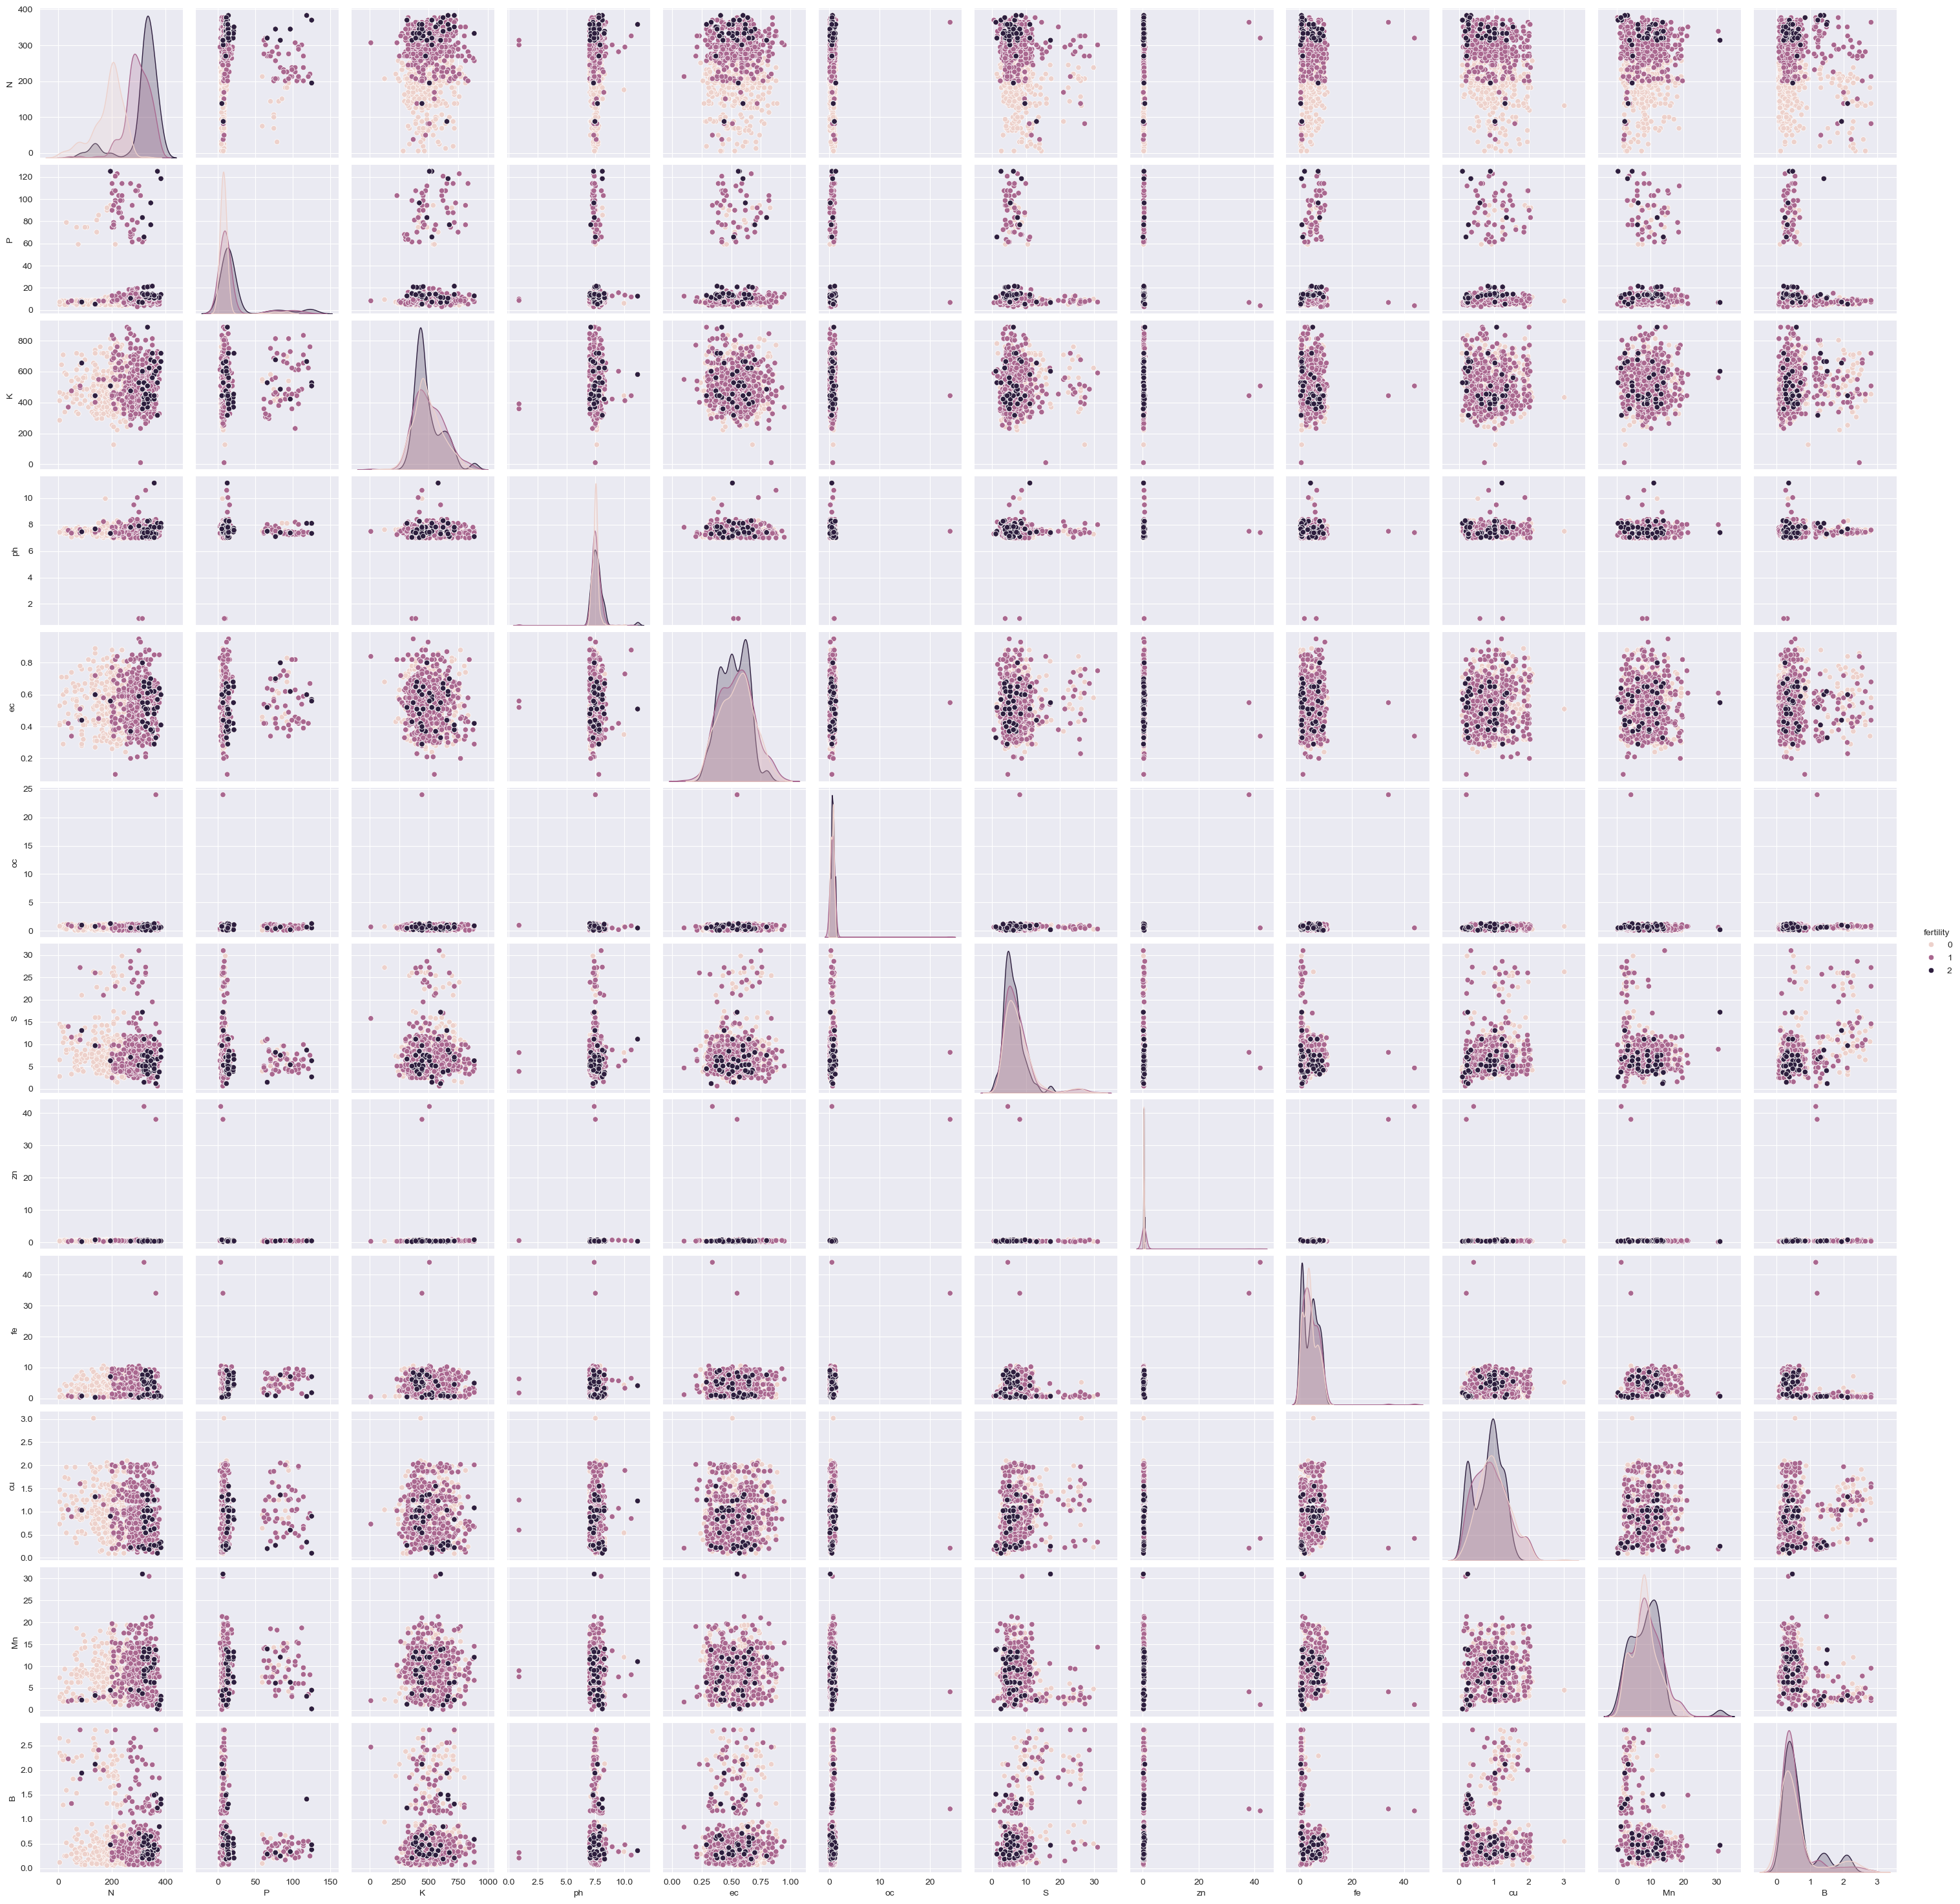

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le dataset
data = pd.read_csv('Soil Fertility Data (Modified Data).csv')  # Remplacez par le chemin de votre fichier
# display(data.head())
# 
# # Vérifier les statistiques descriptives
# display(data.describe())
# 
# # Vérifier les valeurs manquantes
print(data.isnull().sum())

# Visualisation initiale
sns.pairplot(data, hue="fertility", diag_kind="kde")
plt.show()


# 2. Réduction de dimensions avec sélection des variables


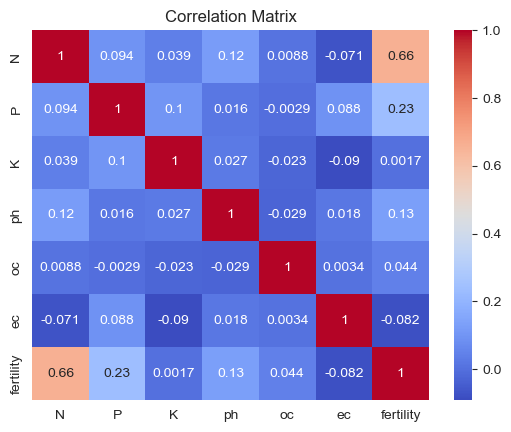

In [4]:
# Sélection des colonnes
selected_columns = ['N', 'P', 'K', 'ph', 'oc', 'ec', 'fertility']
data_reduced = data[selected_columns]

# Vérification de la corrélation des variables
correlation_matrix = data_reduced.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# 3. Analyse en composantes principales (ACP)

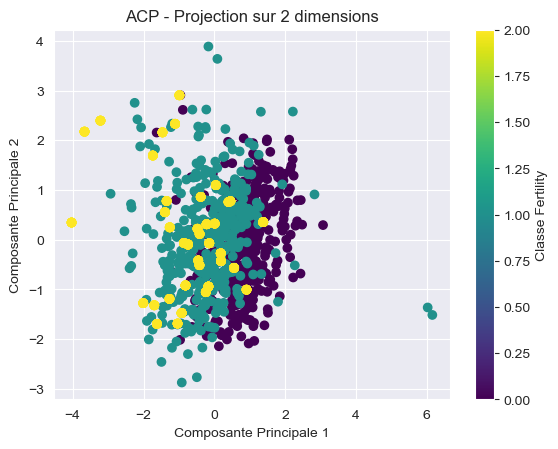

Variance expliquée : [0.20172833 0.1814705 ]


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_reduced.drop(columns=['fertility']))

# Application de l'ACP
pca = PCA(n_components=2)  # Projection sur 2 dimensions
pca_data = pca.fit_transform(scaled_data)

# Visualisation des résultats
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data_reduced['fertility'], cmap='viridis')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('ACP - Projection sur 2 dimensions')
plt.colorbar(label='Classe Fertility')
plt.show()

# Importance des composantes
print(f"Variance expliquée : {pca.explained_variance_ratio_}")


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Séparation des données
X = data_reduced.drop(columns=['fertility'])
y = data_reduced['fertility']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# Entraînement et évaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9728682170542635
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        86
           1       0.97      0.95      0.96        87
           2       1.00      1.00      1.00        85

    accuracy                           0.97       258
   macro avg       0.97      0.97      0.97       258
weighted avg       0.97      0.97      0.97       258

SVM Accuracy: 0.7674418604651163
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        86
           1       0.80      0.52      0.63        87
           2       0.66      0.86      0.74        85

    accuracy                           0.77       258
   macro avg       0.78      0.77      0.76       258
weighted avg       0.78      0.77      0.76       258

KNN Accuracy: 0.8837209302325582
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        86
           1       0

## ON CHOISIRA DONC RANDOM FOREST

In [26]:
rf=models['Random Forest']

# 5. Intégration des données Open-Meteo

In [33]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

def fetch_carbon_monoxide_mean(latitude: float, longitude: float, past_days: int = 14, forecast_days: int = 1) -> float:
    """
    Récupère la concentration moyenne de monoxyde de carbone (CO) pour une localisation donnée
    sur une période définie.

    Args:
        latitude (float): Latitude de la localisation.
        longitude (float): Longitude de la localisation.
        past_days (int): Nombre de jours passés à inclure dans les données. Par défaut, 14.
        forecast_days (int): Nombre de jours de prévisions à inclure. Par défaut, 1.

    Returns:
        float: Concentration moyenne de CO en μg/m³.
               Retourne None si les données sont invalides ou indisponibles.
    """
    # Initialiser la session avec cache et retry
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Paramètres API
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "carbon_monoxide",
        "past_days": past_days,
        "forecast_days": forecast_days
    }

    # Récupération des données de l'API
    try:
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]  # On traite la première localisation

        # Extraction des données horaires de CO
        hourly = response.Hourly()
        hourly_carbon_monoxide = hourly.Variables(0).ValuesAsNumpy()

        # Filtrer les valeurs nulles
        valid_values = hourly_carbon_monoxide[~pd.isnull(hourly_carbon_monoxide)]

        if len(valid_values) > 0:
            print(f"Concentration moyenne de CO : {valid_values.mean()/500} μg/m³")
            return valid_values.mean()/500  # Retourne la moyenne des valeurs valides
        else:
            print("Toutes les données de CO sont manquantes ou invalides.")
            return None
    except Exception as e:
        print(f"Erreur lors de la récupération des données : {e}")
        return None

# Exemple d'utilisation
latitude, longitude = 52.52, 13.41
mean_co = fetch_carbon_monoxide_mean(latitude, longitude)
if mean_co is not None:
    print(f"Concentration moyenne de CO : {mean_co} μg/m³")
else:
    print("Impossible de calculer la concentration moyenne de CO.")


Concentration moyenne de CO : 0.4139055480957031 μg/m³
Concentration moyenne de CO : 0.4139055480957031 μg/m³


# 6. Finalisation du modèle de prédiction
Créer une fonction combinant les données mesurées par les capteurs et la concentration moyenne de CO pour effectuer une prédiction.

In [37]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def predict_fertility(model, data, latitude, longitude):
    # Récupérer la moyenne de CO à partir des coordonnées
    co_mean = fetch_carbon_monoxide_mean(latitude, longitude)
    if co_mean is None:
        print("Erreur dans les données de CO")
        return None
    
    # Ajouter la valeur de CO comme avant-dernière caractéristique
    data_with_co = np.insert(data, -1, co_mean)  # Insérer CO en avant-dernière position
    data_with_co = data_with_co.reshape(1, -1)  # Formater en tableau 2D

    # Créer un DataFrame avec les noms de colonnes
    column_names = ['N', 'P', 'K', 'ph', 'oc', 'ec']  # Ajuster les colonnes pour inclure CO en avant-dernier
    df = pd.DataFrame(data_with_co, columns=column_names)

    # Faire la prédiction avec le modèle
    prediction = model.predict(df)

    return prediction

# Exemple d'utilisation avec des données d'exemple et un modèle fictif
# Créez un modèle aléatoire (vous devrez utiliser votre propre modèle ici)
example_data = [150, 10, 500, 7.5, 1.0]  # Exemple de données capteurs [N, P, K, ph, ec]
latitude = 52.52  # Latitude fictive (par exemple, Paris)
longitude = 13  # Longitude fictive (par exemple, Paris)

# Appliquer la fonction pour prédire la fertilité
prediction = predict_fertility(rf, example_data, latitude, longitude)
print(f"Prediction de la fertilité : {prediction}")


Concentration moyenne de CO : 0.36017221069335936 μg/m³
Prediction de la fertilité : [0]


In [38]:
X_train

,N,P,K,ph,oc,ec
634,314,11.8,359,7.60,1.27,0.52
673,314,8.3,486,7.41,0.57,0.42
823,295,12.5,412,7.12,0.20,0.37
1150,333,20.8,370,7.45,0.20,0.55
135,100,8.3,570,7.44,0.35,0.41
...,...,...,...,...,...,...
1044,358,13.2,444,7.80,0.49,0.29
1095,358,13.2,444,7.80,0.49,0.29
1130,358,12.9,422,7.02,1.27,0.48
860,383,14.0,718,7.80,0.62,0.41


In [40]:
X_train['oc'].describe()

count    1030.000000
mean        0.634049
std         0.790762
min         0.100000
25%         0.390000
50%         0.620000
75%         0.830000
max        24.000000
Name: oc, dtype: float64


```markdown
# Prédiction de la Fertilité des Sols avec Modèle d'Apprentissage Automatique

Ce projet utilise un modèle d'apprentissage automatique pour prédire la fertilité des sols à partir de données capteurs. La fonction de prédiction intègre des données de capteurs (N, P, K, ph, ec) et ajoute une variable externe (la concentration de monoxyde de carbone, CO) basée sur la latitude et la longitude du lieu. Le modèle prédit ensuite la fertilité du sol en fonction de ces caractéristiques.

## Fonctionnalités

- **Entrée des données** : Les données des capteurs (N, P, K, ph, ec) ainsi que la localisation (latitude et longitude) sont utilisées pour générer des prédictions.
- **Prédiction basée sur un modèle Random Forest** : Un modèle d'apprentissage automatique est utilisé pour effectuer la prédiction de la fertilité du sol.
- **Ajout de la concentration de CO** : La fonction intègre un facteur supplémentaire en ajoutant la concentration moyenne de CO en fonction de la latitude et de la longitude du site.
- **Format de données** : Les données sont organisées sous forme de DataFrame, avec des noms de colonnes correspondant aux caractéristiques utilisées pour entraîner le modèle.

## Description du Code

### Fonction `predict_fertility`

Cette fonction prend en entrée :
- `model` : Un modèle d'apprentissage automatique déjà entraîné (par exemple, un modèle `RandomForestClassifier`).
- `data` : Un tableau de données des capteurs sous forme de liste ou tableau (`[N, P, K, ph, ec]`).
- `latitude` : Latitude de la localisation.
- `longitude` : Longitude de la localisation.

### Étapes de la fonction :

1. **Récupérer la concentration de CO** : En utilisant la latitude et la longitude fournies, la fonction appelle `fetch_carbon_monoxide_mean()` pour obtenir la concentration moyenne de CO. Cette étape est cruciale, car elle permet d'ajouter un facteur environnemental dans la prédiction.

2. **Formater les données** : Les données des capteurs et la concentration de CO sont combinées en un tableau d'une seule ligne. Ce tableau est ensuite transformé en un DataFrame avec les noms de colonnes suivants : `['N', 'P', 'K', 'ph', 'ec', 'CO']`.

3. **Prédiction** : Le modèle (par exemple, un Random Forest) est utilisé pour prédire la fertilité du sol basé sur les données combinées. Le modèle renvoie une prédiction, qui peut être soit `1` pour "fertile", soit `0` pour "non fertile", selon la manière dont le modèle a été entraîné.

### Exemple d'utilisation :

```python
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Fonction pour récupérer la moyenne de CO (à implémenter selon votre source)
def fetch_carbon_monoxide_mean(latitude, longitude):
    # Cette fonction doit récupérer les données de CO à partir de l'emplacement
    return 0.5  # Exemple : retourne une valeur de CO moyen

def predict_fertility(model, data, latitude, longitude):
    co_mean = fetch_carbon_monoxide_mean(latitude, longitude)
    if co_mean is None:
        print("Erreur dans les données de CO")
        return None

    data_with_co = np.append(data, co_mean)  # Ajoute CO à la fin des données
    data_with_co = data_with_co.reshape(1, -1)  # Formater en tableau 2D

    # Créer un DataFrame avec les noms de colonnes
    column_names = ['N', 'P', 'K', 'ph', 'ec', 'CO']
    df = pd.DataFrame(data_with_co, columns=column_names)

    # Faire la prédiction avec le modèle
    prediction = model.predict(df)
    return prediction

# Exemple d'utilisation avec des données d'exemple
rf = RandomForestClassifier()
example_data = [150, 10, 500, 7.5, 1.0]  # Exemple de données capteurs [N, P, K, ph, ec]
latitude = 48.8566  # Latitude fictive (par exemple, Paris)
longitude = 2.3522  # Longitude fictive (par exemple, Paris)

# Appliquer la fonction pour prédire la fertilité
prediction = predict_fertility(rf, example_data, latitude, longitude)
print(f"Prediction de la fertilité : {prediction}")
```

### Prérequis

Assurez-vous que les bibliothèques suivantes sont installées :

- `numpy` : Pour manipuler les données numériques.
- `pandas` : Pour gérer les DataFrames.
- `scikit-learn` : Pour utiliser le modèle `RandomForestClassifier`.

Vous pouvez installer ces bibliothèques avec `pip` si nécessaire :

```bash
pip install numpy pandas scikit-learn
```

### Fonction `fetch_carbon_monoxide_mean`

La fonction `fetch_carbon_monoxide_mean(latitude, longitude)` est une fonction fictive dans cet exemple. Vous devrez la remplacer par une fonction réelle qui récupère les données de concentration de monoxyde de carbone à partir d'une API ou d'une base de données en fonction de la localisation (latitude et longitude).

## Conclusion

Ce code permet de prédire la fertilité du sol en utilisant un modèle d'apprentissage automatique basé sur plusieurs capteurs et une donnée externe (concentration de CO). Assurez-vous de remplacer la fonction de récupération de CO par une source de données réelle pour obtenir des prédictions plus précises et adaptées à votre environnement.
```

### Explications du `README.md` :

- **Introduction** : Le fichier commence par une description générale de ce que fait le code et des fonctionnalités principales, telles que l'intégration de la concentration de CO à partir des coordonnées géographiques.
  
- **Fonctionnalités** : Il est expliqué que la fonction de prédiction prend des données capteurs et des coordonnées géographiques pour renvoyer une prédiction de la fertilité du sol, en tenant compte de l'effet du monoxyde de carbone sur cette fertilité.

- **Description du code** : Détaille le processus de la fonction de prédiction, avec un exemple d’utilisation pratique.

- **Exemple d’utilisation** : Fournit un exemple complet de code pour tester la fonction avec un modèle fictif de `RandomForestClassifier`.

- **Prérequis et Installation** : Indique les bibliothèques nécessaires pour exécuter le code et comment les installer.

